**Master Simulation**

Simulation of node states with pre processed distributions for group selection and uptime failures

In [1]:
import random
import simpy
import datetime
import numpy as np
import pandas as pd
import simulation_components as sc
import matplotlib.pyplot as plt

**Initialize Variables**

In [2]:
group_size = 5 # Group size
runs = 5 # number of runs/cycles
total_tickets = 50000 # total virtual stakers
nodes = 5 # number of nodes
tickets = [] # initializing the array that will contain the tickets
group_members = [] # initializing the array that will contain indexes(node #) of tickets for each group
sim_cycles = 5 # maximum node cycles

**Simulation Inputs**

Text(0.5, 1.0, 'Virtual Staker Cumulative Distribution')

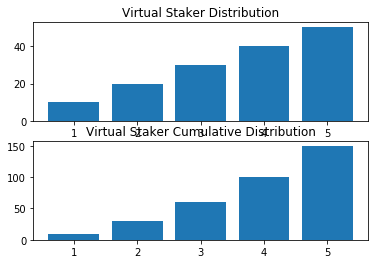

In [3]:
# Pre-processing Staker distributions
# Linear y = m * (x + 1) since indices start from 0
L02 = np.zeros(nodes) 

for i in range (0,nodes):
    L02[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, L02)
plt.title("Virtual Staker Distribution")

cdf_L02=sc.create_cdf(nodes,L02)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")

**Pre-processed tickets and groups**

In [4]:
tickets = sc.preprocess_tickets(runs, total_tickets) # generates a size(total tickets x runs) matrix of tickets by sampling the uniform distribution
group_members = sc.preprocess_groups(tickets, runs, group_size) # generates a size (nodes x runs) matrix of group members


In [5]:
def group_distr(runs, nodes, group_members, cdf):
# function to calculate group ownership distribution
# need to add to sim components
    total_group_distr = np.zeros(nodes)
    max_owned = np.zeros(runs)
    group_distr_matrix = np.zeros((runs,nodes))
    for i in range(runs):
        group_distr = np.zeros(nodes)
        group_distr[1] = sum(group_members[i]<cdf[0])
        for j in range(1,nodes):
            group_distr[j] = sum(group_members[i]<cdf[j])-sum(group_members[i]<cdf[j-1])
        max_owned[i] = max(group_distr)/sum(group_distr)
        total_group_distr +=group_distr
        group_distr_matrix[i] = group_distr #saves the group ticket distribution for each run
    return total_group_distr, max_owned, group_distr_matrix

total_group_distr, max_owned, group_distr_matrix = group_distr(runs, nodes, group_members, cdf_L02)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


**Pre-processed node failure modes**

In [6]:
failed_nodes = sc.node_failure_modes(nodes, runs)

In [7]:
print(failed_nodes)

[[False False False  True False]
 [False False False False False]
 [False False False  True False]
 [False False False False False]
 [False False False False False]]


**Create Nodes and Start Simulation Environment**

In [8]:
env = simpy.Environment()
print("creating nodes")

node_array = [sc.Node(env, 'Node %d' % i, datetime.datetime.now(), tickets)
            for i in range(1)]

print("creating groups")
group_array = [sc.Group(env, i, group_size, group_distr_matrix)
            for i in range(5)]

proc = env.process(sc.relay_entry(env, 5, group_array, node_array))

env.run(until=proc)

df = []
for n in node_array:
    df.append([n.id, n.number_of_entries_generated
               , n.relay_request_time
               , n.relay_entry_watch_time
               , sum(n.groups_joined)])
    
df = pd.DataFrame(df)
df.columns=["id", "number_of_entries_generated", "relay_request_time", "relay_entry_watch_time", "Total groups joined"]
df

creating nodes
creating groups
Node 0 ethereum connection Failurecycle=0
run # = 1
run # = 2
run # = 3
run # = 4
run # = 5


,id,number_of_entries_generated,relay_request_time,relay_entry_watch_time,Total groups joined
0,Node 0,0,0,0,0


**Simulation Results**